# Fine amplitude calibration

The amplitude of a pulse can be precisely calibrated using error amplifying gate sequences. These gates sequences apply a variable number of times the same gate. Therefore, if each gate has a small error $\delta\theta$ in the rotation angle then a sequence of $n$ gates will have a rotation error of $n\cdot\delta\theta$. We will work with *ibmq_armonk* and compare our results to those reported by the backend.

In [1]:
import numpy as np

from qiskit_experiments.calibration.experiments.fine_amplitude import FineAmplitude
import qiskit.pulse as pulse

from qiskit import IBMQ

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')

In [3]:
qubit = 0

In [4]:
x_pulse = backend.defaults().instruction_schedule_map.get('x', (qubit,)).instructions[0][1].pulse
x_pulse

Drag(duration=320, amp=(0.8025730270244306+0j), sigma=80, beta=-0.6947325950922032, name='Xp_d0')

In [5]:
ideal_amp = x_pulse.amp
print(f"The reported amplitude of the X pulse is {ideal_amp:.4f}.")

The reported amplitude of the X pulse is 0.8026+0.0000j.


### Detect an over-rotated pulse

We now take the x pulse reported by the backend and add a 10% overrotation to it by scaling the amplitude and see if the experiment can detect this overrotation.

In [6]:
pulse_amp = ideal_amp*1.1
target_angle = np.pi

with pulse.build(backend=backend, name="xp") as xp_over:
    pulse.play(
        pulse.Drag(
            duration=x_pulse.duration, amp=pulse_amp, sigma=x_pulse.sigma, beta=x_pulse.beta
        ), 
        pulse.drive_channel(qubit)
    )

In [7]:
amp_cal = FineAmplitude(qubit)
amp_cal.set_schedule(schedule=xp_over, angle_per_gate=target_angle, phase_offset=np.pi / 2)
amp_cal.set_experiment_options(add_sx=True)

Observe here that we added a square-root of X pulse before appyling the error amplifying sequence. This is done to be able to distinguish between over-rotated and under-rotated pulses.

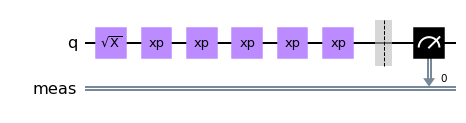

In [8]:
amp_cal.circuits(backend)[5].draw(output="mpl")

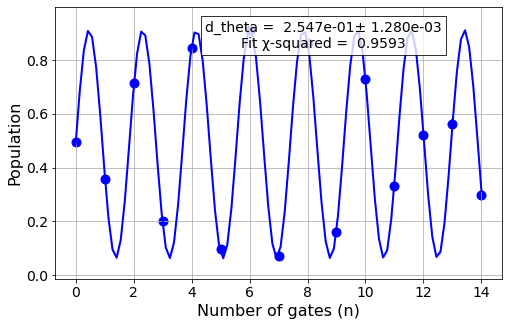

In [9]:
data_over = amp_cal.run(backend)

In [10]:
result = data_over.analysis_result(-1)
result

{'analysis_type': 'FineAmplitudeAnalysis',
 'popt': array([-0.84684176,  0.25469958,  0.48750955]),
 'popt_keys': ['amp', 'd_theta', 'baseline'],
 'popt_err': array([0.00807297, 0.00127993, 0.00307701]),
 'pcov': array([[ 6.51728185e-05, -1.05309547e-06, -2.31724472e-06],
        [-1.05309547e-06,  1.63821646e-06,  1.82246446e-07],
        [-2.31724472e-06,  1.82246446e-07,  9.46796990e-06]]),
 'reduced_chisq': 0.9593124298328782,
 'dof': 12,
 'xrange': [0.0, 14.0],
 'quality': 'computer_good',
 'success': True}

In [12]:
dtheta = result["popt"][1]
scale = target_angle / (target_angle + dtheta)
print(f"The ideal angle is {target_angle:.2f} rad. We measured a deviation of {dtheta:.3f} rad.")
print(f"Thus, scale the {pulse_amp:.4f} pulse amplitude by {scale:.3f} to obtain {pulse_amp*scale:.5f}.")
print(f"Amplitude reported by the backend {ideal_amp:.4f}.")

The ideal angle is 3.14 rad. We measured a deviation of 0.255 rad.
Thus, scale the 0.8828+0.0000j pulse amplitude by 0.925 to obtain 0.81662+0.00000j.
Amplitude reported by the backend 0.8026+0.0000j.


### Detect an under-rotated pulse

In [13]:
pulse_amp = ideal_amp*0.9
target_angle = np.pi

with pulse.build(backend=backend, name="xp") as xp_under:
    pulse.play(
        pulse.Drag(
            duration=x_pulse.duration, amp=pulse_amp, sigma=x_pulse.sigma, beta=x_pulse.beta
        ), 
        pulse.drive_channel(qubit)
    )

In [14]:
amp_cal = FineAmplitude(qubit)
amp_cal.set_schedule(schedule=xp_under, angle_per_gate=target_angle, phase_offset=np.pi / 2)
amp_cal.set_experiment_options(add_sx=True)

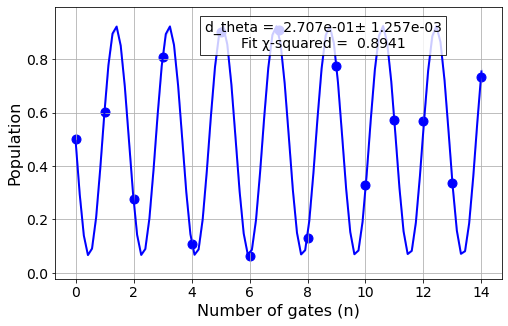

In [15]:
data_under = amp_cal.run(backend)

In [16]:
result = data_under.analysis_result(-1)
result

{'analysis_type': 'FineAmplitudeAnalysis',
 'popt': array([0.86195247, 0.27072346, 0.49428734]),
 'popt_keys': ['amp', 'd_theta', 'baseline'],
 'popt_err': array([0.00782487, 0.00125719, 0.00301782]),
 'pcov': array([[ 6.12285757e-05,  1.97239922e-07,  8.34069546e-07],
        [ 1.97239922e-07,  1.58053156e-06, -1.73788643e-07],
        [ 8.34069546e-07, -1.73788643e-07,  9.10725787e-06]]),
 'reduced_chisq': 0.8941479593718705,
 'dof': 12,
 'xrange': [0.0, 14.0],
 'quality': 'computer_good',
 'success': True}

In [17]:
dtheta = result["popt"][1]
scale = target_angle / (target_angle + dtheta)
print(f"The ideal angle is {target_angle:.2f} rad. We measured a deviation of {dtheta:.3f} rad.")
print(f"Thus, scale the {pulse_amp:.4f} pulse amplitude by {scale:.3f} to obtain {pulse_amp*scale:.5f}.")
print(f"Amplitude reported by the backend {ideal_amp:.4f}.")

The ideal angle is 3.14 rad. We measured a deviation of 0.271 rad.
Thus, scale the 0.7223+0.0000j pulse amplitude by 0.921 to obtain 0.66501+0.00000j.
Amplitude reported by the backend 0.8026+0.0000j.


### Analyze a pi-half pulse

We now consider the pi-half rotation. Note that in this case we do not need to add a pi-half rotation to the circuits.

In [18]:
pulse_amp = ideal_amp / 2
target_angle = np.pi / 2

with pulse.build(backend=backend, name="x90p") as x90p:
    pulse.play(
        pulse.Drag(
            duration=x_pulse.duration, amp=pulse_amp, sigma=x_pulse.sigma, beta=x_pulse.beta
        ), 
        pulse.drive_channel(qubit)
    )

In [19]:
amp_cal.set_schedule(schedule=x90p, angle_per_gate=target_angle, phase_offset=0.0)
amp_cal.circuits(backend)[5].draw(output="mpl")
amp_cal.set_experiment_options(add_sx=False)

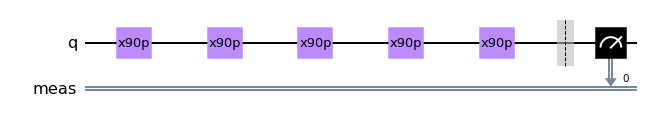

In [20]:
amp_cal.circuits(backend)[5].draw(output="mpl")

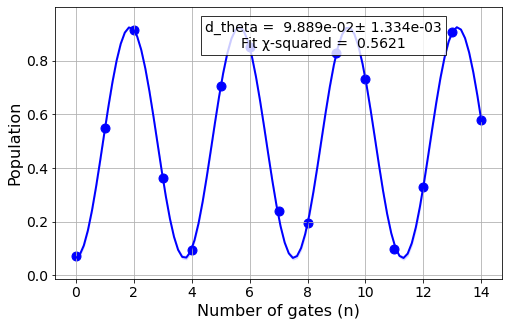

In [21]:
data_x90p = amp_cal.run(backend)

In [22]:
result = data_x90p.analysis_result(-1)
result

{'analysis_type': 'FineAmplitudeAnalysis',
 'popt': array([-0.86023358,  0.09889368,  0.49421913]),
 'popt_keys': ['amp', 'd_theta', 'baseline'],
 'popt_err': array([0.00720281, 0.00133372, 0.00290288]),
 'pcov': array([[ 5.18804567e-05,  6.70587566e-07, -1.06518449e-06],
        [ 6.70587566e-07,  1.77881155e-06,  9.74444027e-08],
        [-1.06518449e-06,  9.74444027e-08,  8.42669046e-06]]),
 'reduced_chisq': 0.5620795051855217,
 'dof': 12,
 'xrange': [0.0, 14.0],
 'quality': 'computer_good',
 'success': True}

In [23]:
sx = backend.defaults().instruction_schedule_map.get('sx', (qubit,))
sx_ideal_amp = sx.instructions[0][1].pulse.amp

dtheta = result["popt"][1]
scale = target_angle / (target_angle + dtheta)
print(f"The ideal angle is {target_angle:.2f} rad. We measured a deviation of {dtheta:.3f} rad.")
print(f"Thus, scale the {pulse_amp:.4f} pulse amplitude by {scale:.3f} to obtain {pulse_amp*scale:.5f}.")
print(f"Amplitude reported by the backend {sx_ideal_amp:.4f}.")

The ideal angle is 1.57 rad. We measured a deviation of 0.099 rad.
Thus, scale the 0.4013+0.0000j pulse amplitude by 0.941 to obtain 0.37752+0.00000j.
Amplitude reported by the backend 0.3694-0.0757j.
